#Setup Google Drive

In [1]:
# mount Google Drive
from google.colab import drive
#drive/MyDrive/Colab/thesis_2
drive.mount("/content/drive/")
path = "/content/drive/My Drive/"

# ------- ------- -------
import sys
sys.path.insert(0,"/content/drive/My Drive/")

Mounted at /content/drive/


In [2]:
#!pip install farasapy
#!pip install pyarabic
#import PX_preprocessing
! pip install keras_tuner
! pip install autokeras
! pip install tensorflow_addons


In [3]:
#!pip install -q cloud-tpu-client # Needed for sync TPU version

In [4]:
# import essential libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -=-=-=-=-=-=-===-==-==-=
import keras
from keras import metrics
from keras.layers import Dense, GRU, Embedding, Bidirectional, Dropout, LSTM
from keras.models import Sequential

# -=-=-=-=-=-=-===-==-==-=
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import backend as K
#import keras_tuner as kt
#import autokeras as ak
#import tensorflow_addons as tfa

"""val_fbeta_score = tfa.metrics.F1Score(num_classes=25, average="micro", threshold=None)
print( id(val_fbeta_score))"""

'val_fbeta_score = tfa.metrics.F1Score(num_classes=25, average="micro", threshold=None)\nprint( id(val_fbeta_score))'

# 1.Preparation:
* BiLSTM + Word Embeddings (built specifically for PX)


* The BiLSTM model is going to classify to multiple classes (multi-label classification).

--------

### 1.1 Load dataset
and create an embedding for it.

In [6]:
px_df1 = pd.read_csv(path+'all_subcategories_xcleaned.csv')
#px_df1.drop(columns='Unnamed: 0', inplace=True)
px_df1.head(2)

,Unnamed: 0,Journey,Journey#refnumber,comment,xclean,rating,classes,Examination,Patient_Journey,Quality_Care,...,Access,Patient_Disposition,Delays,Referrals,Patient-Staff_Communication,Incorrect_Information,Emotional_Support,Assault_Harassment,Confidentiality,Consent
0,0,PCU,PCU000001,الدكتور لا يتكلم مع المريض ولا يلبس القفازات و...,الدكتور يتكلم المريض يلبس القفازات يدلي باي مع...,Negative,غير مهتم باحتياجات المريض -رعاية طبية دون ال...,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1,1,PCU,PCU000002,الشي الوحيد الذي تضيقت منه في زياره سابقه وليس...,الشي الوحيد تضيقت زياره سابقه وليست اخر زياره ...,Negative,غير مهتم باحتياجات المريض- انتهاك خصوصية المري...,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [7]:
print('shape before dropping possible NA rows: ' ,px_df1.shape)
px_df1.dropna(axis = 0 , how='any', inplace=True) #,'cleaned_comment'
print('shape after dropping possible NA rows: ' ,px_df1.shape)

shape before dropping possible NA rows:  (14426, 32)
shape after dropping possible NA rows:  (14423, 32)


In [8]:
px_df1.head(2)

,Unnamed: 0,Journey,Journey#refnumber,comment,xclean,rating,classes,Examination,Patient_Journey,Quality_Care,...,Access,Patient_Disposition,Delays,Referrals,Patient-Staff_Communication,Incorrect_Information,Emotional_Support,Assault_Harassment,Confidentiality,Consent
0,0,PCU,PCU000001,الدكتور لا يتكلم مع المريض ولا يلبس القفازات و...,الدكتور يتكلم المريض يلبس القفازات يدلي باي مع...,Negative,غير مهتم باحتياجات المريض -رعاية طبية دون ال...,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1,1,PCU,PCU000002,الشي الوحيد الذي تضيقت منه في زياره سابقه وليس...,الشي الوحيد تضيقت زياره سابقه وليست اخر زياره ...,Negative,غير مهتم باحتياجات المريض- انتهاك خصوصية المري...,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [9]:
px_df1.drop(inplace=True,columns=['Journey','Journey#refnumber','comment','rating','classes','Unnamed: 0'] ,)

In [10]:
#px_df1 = px_df1.sample(frac=1) #shuffle
#px_df1.dropna(how='any' ).shape
px_df1.head(2)

,xclean,Examination,Patient_Journey,Quality_Care,Treatment,Diagnosis,Medication_Vaccination,Safety_Inceidents,Skills_conducts,Administrative_Policies_procedures,...,Access,Patient_Disposition,Delays,Referrals,Patient-Staff_Communication,Incorrect_Information,Emotional_Support,Assault_Harassment,Confidentiality,Consent
0,الدكتور يتكلم المريض يلبس القفازات يدلي باي مع...,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,الشي الوحيد تضيقت زياره سابقه وليست اخر زياره ...,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
px_df1.xclean.astype(str)

0        الدكتور يتكلم المريض يلبس القفازات يدلي باي مع...
1        الشي الوحيد تضيقت زياره سابقه وليست اخر زياره ...
2        اوصل للمستوصف ويكون مافي تعقيم طيب واذا الشخص ...
3        رفعت شكوي مسبقه وتم حلها والحمدلله لاكن الدكات...
4        منطقه الانتظار المركز غرفه الدكتور بقسم الرجال...
                               ...                        
14421                                         الغرفه بارده
14422               طفلي ماعطو التطعيم ودايما اولد ويعطوهم
14423                              المظهر سيي والغرفه سييه
14424    نقلي لثلاث غرف بسب النظافه التلفزيون المكيف ال...
14425                -نقص اداوات النظافه الديتول والمناديل
Name: xclean, Length: 14423, dtype: object

In [12]:
"""
x_tr ,x_te, y_tr, y_te = train_test_split(px_df1['cleaned_comment'] , px_df1[['Examination','Patient_Journey','Quality_Care','Treatment','Diagnosis','Medication_Vaccination','Safety_Inceidents','Skills_conducts','Administrative_Policies_procedures','Environment','Safety_Security','Finance_Billing','Staffing','Resources',
'Medical_Records','Access','Patient_Disposition','Delays',
'Referrals','Patient-Staff_Communication','Incorrect_Information','Emotional_Support','Assault_Harassment','Confidentiality',
'Consent']], test_size=0.2)

"""

"\nx_tr ,x_te, y_tr, y_te = train_test_split(px_df1['cleaned_comment'] , px_df1[['Examination','Patient_Journey','Quality_Care','Treatment','Diagnosis','Medication_Vaccination','Safety_Inceidents','Skills_conducts','Administrative_Policies_procedures','Environment','Safety_Security','Finance_Billing','Staffing','Resources',\n'Medical_Records','Access','Patient_Disposition','Delays',\n'Referrals','Patient-Staff_Communication','Incorrect_Information','Emotional_Support','Assault_Harassment','Confidentiality',\n'Consent']], test_size=0.2)\n\n"

### 1.2 Split the dataset for training and testing (**run for all options**)
Here we should somehow make stratified data split.
also consider K-fold cross validation when training the model.


*hopefully this applies for the multi-label dataset*

In [13]:
cols = px_df1.columns[1:]
print(cols , '\t\t\t\n\n' , len(cols))

Index(['Examination', 'Patient_Journey', 'Quality_Care', 'Treatment',
       'Diagnosis', 'Medication_Vaccination', 'Safety_Inceidents',
       'Skills_conducts', 'Administrative_Policies_procedures', 'Environment',
       'Safety_Security', 'Finance_Billing', 'Staffing', 'Resources',
       'Medical_Records', 'Access', 'Patient_Disposition', 'Delays',
       'Referrals', 'Patient-Staff_Communication', 'Incorrect_Information',
       'Emotional_Support', 'Assault_Harassment', 'Confidentiality',
       'Consent'],
      dtype='object') 			

 25


In [14]:
X = px_df1['xclean']
Y = px_df1[cols]

In [15]:
#int(False)
#int(True)

# now convert the results of prediction into integer rather than float
def convert_preds(y_preds):
  # 1st convert from float to boolean
  y_pred1_bool = (y_preds > 0.5)
  #print(y_pred1_bool[0:2])

  # 2nd match the boolean to integer
  y_pred1_int = []
  for row in y_pred1_bool:
    temp = []
    for j in row:
      if j: # if True
        temp.append(1)
      else: # if False
        temp.append(0)
    y_pred1_int.append(temp)

  #print("first 2 rows:\n" ,y_pred1_int[0:2])
  return y_pred1_int

In [16]:
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
#history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)

In [ ]:
# let's see the lengths of the comments
comments_len = pd.DataFrame()
comments_len.head(2)
#print (len(comments_len.cleaned_comment[2]))

""


In [ ]:
lengths = []
for i in comments_len.cleaned_comment:
    #print(i)
    lengths.append(len(i))
    
comments_len['length'] = lengths # i can assign this to the px_df1 cin correspondence to each comment.
comments_len.head(2)

AttributeError: ignored

In [ ]:
print(comments_len.dtypes)

In [ ]:
comments_len.describe() # mean is 125 characters

In [ ]:
import gensim
from gensim.models import word2vec
#from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
#from keras.preprocessing.sequence import pad_sequences

In [ ]:
# load the pre-trained model:
path1 = '/Users/najla/nlp_models/full_grams_sg_300_twitter/full_grams_sg_300_twitter.mdl'
aravec_model = gensim.models.Word2Vec.load(path1)

In [ ]:
print(type(aravec_model))
print(aravec_model.wv.vector_size)
print(aravec_model.wv.vectors[0:4])

In [ ]:
# count number of tokens

# tokenizing the comments using Keras tokenizer
tokenizer = Tokenizer()#lower=False)

# fit the tokenizer with the cleaned comments:
tokenizer.fit_on_texts(px_df1['cleaned_comment']) #this might be only the training set

# THESE ARE FOR TRAINING THE MODEL USING MY DATA.
# save the encoded text (AKA embeddings) in a variable
comments_embeddings = tokenizer.texts_to_sequences(px_df1['cleaned_comment'])

In [ ]:
from collections import OrderedDict
print(comments_embeddings[2], ' comment: \n' , px_df1.cleaned_comment[2])

"""
# save the ordered list of the tokens in a file
#print('\n size: ' , tokenizer.word_counts) # OrderedDict([('عدم', 1402), ('وجود', 629), ('مختبر', 48), ('صغر', 7),...
od = tokenizer.word_counts
od = OrderedDict(sorted(od.items(), key=lambda t: t[1])) # reverse = True
f = open('ordereddict.txt', 'w', encoding='utf8')

for key, value in od.items():
    f.write(key +'\t'+ str(value) +'\n')
    
f.close()
"""

In [ ]:
# pad the embeddings to make them in a uniform length
MAX_LENGTH = 300 # 2× third quartile (75% of the data)
padded_comments = pad_sequences(comments_embeddings, maxlen= MAX_LENGTH, padding='post', truncating='post')
print(len(comments_embeddings[0]) , 'after padding : ' , len(padded_comments[0]))

In [ ]:
# split the dataset of the utilized Word Embeddings
x_tr = padded_comments [0:11541]
x_te = padded_comments [11541:]
y_tr = px_df1[['Examination','Patient_Journey','Quality_Care','Treatment','Diagnosis','Medication_Vaccination','Safety_Inceidents','Skills_conducts','Administrative_Policies_procedures','Environment','Safety_Security','Finance_Billing','Staffing','Resources',
'Medical_Records','Access','Patient_Disposition','Delays',
'Referrals','Patient-Staff_Communication','Incorrect_Information','Emotional_Support','Assault_Harassment','Confidentiality',
'Consent']] [0:11541]
y_te = px_df1[['Examination','Patient_Journey','Quality_Care','Treatment','Diagnosis','Medication_Vaccination','Safety_Inceidents','Skills_conducts','Administrative_Policies_procedures','Environment','Safety_Security','Finance_Billing','Staffing','Resources',
'Medical_Records','Access','Patient_Disposition','Delays',
'Referrals','Patient-Staff_Communication','Incorrect_Information','Emotional_Support','Assault_Harassment','Confidentiality',
'Consent']] [11541:]

### 1.4 Loading the PX customized static word embeddingds

In [17]:
import gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
gensim.__version__

'3.6.0'

In [19]:
px_we = gensim.models.Word2Vec.load(path+'language_models/px_giant_sg_160.model')
sequence_len = px_we.wv.vector_size
print('vocab size = ',len(px_we.wv.vocab),'\nvector sequence length = ',sequence_len)

vocab size =  160136 
vector sequence length =  128


In [20]:
vocab = px_we.wv.vocab

In [21]:
vocab = list(vocab.keys())

In [22]:
vocab[0:2]

['كراسي', 'انتظار']

In [23]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=px_we.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  160136


In [24]:
word_vec_dict.get('دوا') == px_we.wv.get_vector('دوا')

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]

In [25]:
len(px_we.wv.get_vector('دوا'))

128

In [26]:
#tokens = px_we.wv.index2word
px_we.most_similar('طبيب')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('دكتور', 0.8568837642669678),
 ('طبييب', 0.8364349007606506),
 ('طيبب', 0.8318480253219604),
 ('استشاري', 0.8119493722915649),
 ('وطبيب', 0.8073684573173523),
 ('طيبي', 0.7697944045066833),
 ('اخصايي', 0.7670962810516357),
 ('لطبيب', 0.7557195425033569),
 ('بطبيب', 0.7503217458724976),
 ('الاطبيب', 0.7383561730384827)]

In [27]:
#https://www.kaggle.com/code/rajmehra03/a-complete-text-classfication-guide-word2vec-lstm/notebook
from keras.preprocessing.text import Tokenizer#,one_hot
tok = Tokenizer()
tok.fit_on_texts(X)
vocab_size = len(tok.word_index) + 1
encd_comments = tok.texts_to_sequences(X)

In [28]:
vocab_size

34222

In [29]:
MAX_LENGTH = 300
#MAX_LENGTH = sequence_len # make sure it's greater than the third quartile (75% of the data)
padded_comments = pad_sequences(encd_comments, maxlen= MAX_LENGTH, padding='post', truncating='post') #.   MAX_LENGTH
print(len(encd_comments[0]) , 'after padding : ' , len(padded_comments[0]))

19 after padding :  300


In [30]:
print(padded_comments.shape)

(14423, 300)


In [31]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, MAX_LENGTH))
# create an embedding vector that contains the common words in the pretrained AraVec and my dataset
not_found =[]

for word, i in tok.word_index.items():
    #print(i)
    try:
        #embedding_vector = px_we.wv.get_vector(word)
        embedding_vector = pad_sequence(px_we.wv.get_vector(word),maxlen= MAX_LENGTH, padding='post', truncating='post')
    except:
        not_found.append(word)
        embedding_vector = np.zeros((1, MAX_LENGTH))
        pass
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(len(not_found))
print(len(px_we.wv.vocab))
print(len(tok.word_index))

34221
160136
34221


In [32]:
len(embedding_matrix[0])

300

#2.Modelling

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def recall_sklearn(y_true, y_pred):
    return recall_score(y_true, y_pred, average='macro', zero_division=1)

def precision_sklearn(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro', zero_division=1)

def f1_sklearn(y_true, y_pred):
    return f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=1)

def accuracy_sklearn(y_true, y_pred):
  return accuracy_score(y_true, y_pred)

### Option 2.1: use the BiLSTM and the PX WE with traditional dataset split

In [51]:
len(cols)

25

In [52]:
# split the dataset, THE TRADITIONAL WAY.
fifth = int(px_df1.shape[0]/5) * 4 # first 4 fifths for training, the last for testing
x_tr = padded_comments [0:fifth]
x_te = padded_comments [fifth:]
y_tr = px_df1[cols][0:fifth]
y_te = px_df1[cols][fifth:]
"""y_tr = px_df1[['Examination','Patient_Journey','Quality_Care','Treatment','Diagnosis','Medication_Vaccination','Safety_Inceidents','Skills_conducts','Administrative_Policies_procedures','Environment','Safety_Security','Finance_Billing','Staffing','Resources',
'Medical_Records','Access','Patient_Disposition','Delays',
'Referrals','Patient-Staff_Communication','Incorrect_Information','Emotional_Support','Assault_Harassment','Confidentiality',
'Consent']] [0:fifth]
y_te = px_df1[['Examination','Patient_Journey','Quality_Care','Treatment','Diagnosis','Medication_Vaccination','Safety_Inceidents','Skills_conducts','Administrative_Policies_procedures','Environment','Safety_Security','Finance_Billing','Staffing','Resources',
'Medical_Records','Access','Patient_Disposition','Delays',
'Referrals','Patient-Staff_Communication','Incorrect_Information','Emotional_Support','Assault_Harassment','Confidentiality',
'Consent']] [fifth:]"""

"y_tr = px_df1[['Examination','Patient_Journey','Quality_Care','Treatment','Diagnosis','Medication_Vaccination','Safety_Inceidents','Skills_conducts','Administrative_Policies_procedures','Environment','Safety_Security','Finance_Billing','Staffing','Resources',\n'Medical_Records','Access','Patient_Disposition','Delays',\n'Referrals','Patient-Staff_Communication','Incorrect_Information','Emotional_Support','Assault_Harassment','Confidentiality',\n'Consent']] [0:fifth]\ny_te = px_df1[['Examination','Patient_Journey','Quality_Care','Treatment','Diagnosis','Medication_Vaccination','Safety_Inceidents','Skills_conducts','Administrative_Policies_procedures','Environment','Safety_Security','Finance_Billing','Staffing','Resources',\n'Medical_Records','Access','Patient_Disposition','Delays',\n'Referrals','Patient-Staff_Communication','Incorrect_Information','Emotional_Support','Assault_Harassment','Confidentiality',\n'Consent']] [fifth:]"

In [53]:
print( x_tr.shape , 'x testing set shape: ' , x_te.shape)
print( y_tr.shape , 'y training set shape: ' , y_te.shape)

(11536, 300) x testing set shape:  (2887, 300)
(11536, 25) y training set shape:  (2887, 25)


In [54]:
#embedding_matrix[6]-px_we.wv['لا']

In [66]:
# stack the layers
#from keras import metrics
#from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
#from keras.models import Sequential
#MAX_LENGTH = 300
model1 = Sequential(name='BiLSTM_PX_W2V')

model1.add(Embedding(vocab_size, MAX_LENGTH ,weights=[embedding_matrix] , input_length=MAX_LENGTH))
model1.add(Bidirectional(LSTM(128,return_sequences=True)))
model1.add(Dropout(0.2))
model1.add(Bidirectional(LSTM(128)))
model1.add(Dropout(0.2))
model1.add(Dense(25, activation='sigmoid')) # ------------------- changed when combined 6 classes into OTHER.

model1.compile(optimizer='adam' , loss='binary_crossentropy', 
               metrics=['acc',f1_m,precision_m, recall_m,metrics.Precision(), metrics.Recall(),metrics.AUC(),metrics.FalseNegatives(),metrics.FalsePositives(), metrics.TrueNegatives(),metrics.TruePositives(),])
#metrics.AUC(), metrics.CategoricalAccuracy(),metrics.Recall(),metrics.Precision(),metrics.FalseNegatives(),metrics.FalsePositives(), metrics.TrueNegatives(),metrics.TruePositives()])
#'categorical_accuracy','sparse_categorical_accuracy'])

In [67]:
model1.summary()

Model: "BiLSTM_PX_W2V"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 300, 300)          10266600  
                                                                 
 bidirectional_22 (Bidirecti  (None, 300, 256)         439296    
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 300, 256)          0         
                                                                 
 bidirectional_23 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 25)              

In [ ]:
# training the model
history1 = model1.fit(x_tr, y_tr, batch_size=128 , epochs= 10)

In [ ]:
# Evaluate the model
#model1.evaluate(x_te,y_te)
evaluation = model1.evaluate(x_te,y_te)

In [60]:
# predict
y_pred1 = model1.predict(x_te,)

91/91 [==============================] - 4s 24ms/step


In [61]:
# I tried to use different measures, such as f1(w,macro), Recall, Precision in addition to the accuracy.

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score#, multilabel_confusion_matrix
y_pred1_int = convert_preds(y_pred1)
print(classification_report(y_te,y_pred1_int))
print(accuracy_score(y_te,y_pred1_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        10
           2       0.44      0.50      0.47       399
           3       0.00      0.00      0.00        99
           4       0.00      0.00      0.00        17
           5       0.81      0.43      0.56       115
           6       0.00      0.00      0.00        63
           7       0.00      0.00      0.00        16
           8       0.23      0.04      0.07        75
           9       0.89      0.84      0.86      1246
          10       0.00      0.00      0.00        37
          11       0.00      0.00      0.00         7
          12       0.29      0.13      0.18        47
          13       0.26      0.04      0.08       113
          14       0.00      0.00      0.00        23
          15       0.59      0.38      0.47        78
          16       0.00      0.00      0.00         2
          17       0.63    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [62]:
if False:
  #cf1 = multilabel_confusion_matrix(y_te.to_numpy(),np.ceil(np.round(y_pred1)))
  #print(cf1)
  ##print(confusion_matrix(y_te.to_numpy(),np.ceil(np.round(y_pred1))))
  ##np.ceil(np.round(y_pred1[0:3]))
  tn1 = cf1[:, 0, 0]
  tp1 = cf1[:, 1, 1]
  fn1 = cf1[:, 1, 0]
  fp1 = cf1[:, 0, 1]
  print(tn1 , '\n',tp1, '\n', fn1 ,'\n' , fp1)

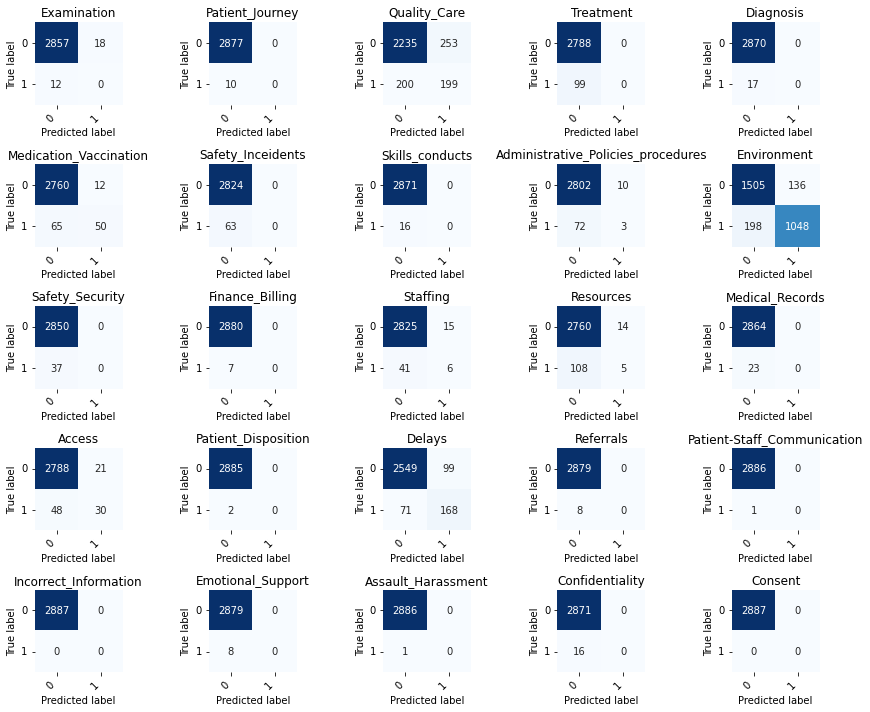

In [63]:
from sklearn.metrics import  multilabel_confusion_matrix
cf_bilstm1 = multilabel_confusion_matrix(y_te,y_pred1_int)
import PlotConfusion
PlotConfusion.print_cf(cf_bilstm1,cols)

### Option 2.2: use BiLSTM and PX WE with KFold corss validation

In [33]:
print('X variables type is: ',type(padded_comments),'\n Y variable type is: ',type(Y))
print('\n')
print('X variables len is: ',len(padded_comments),'\n Y variable len is: ',len(Y))

X variables type is:  <class 'numpy.ndarray'> 
 Y variable type is:  <class 'pandas.core.frame.DataFrame'>


X variables len is:  14423 
 Y variable len is:  14423


In [34]:
Y.head(2)

,Examination,Patient_Journey,Quality_Care,Treatment,Diagnosis,Medication_Vaccination,Safety_Inceidents,Skills_conducts,Administrative_Policies_procedures,Environment,...,Access,Patient_Disposition,Delays,Referrals,Patient-Staff_Communication,Incorrect_Information,Emotional_Support,Assault_Harassment,Confidentiality,Consent
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
Y_list = px_df1[cols].to_numpy() #convert_preds(Y.to_numpy())
Y_list[0:2]

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0]])

In [36]:
# split the dataset, THE KFold CROSS VALIDATION way ----------------
#https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md#adding-k-fold-cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
"""Y = px_df1[['Examination','Patient_Journey','Quality_Care','Treatment','Diagnosis','Medication_Vaccination','Safety_Inceidents','Skills_conducts','Administrative_Policies_procedures','Environment','Safety_Security','Finance_Billing','Staffing','Resources',
'Medical_Records','Access','Patient_Disposition','Delays',
'Referrals','Patient-Staff_Communication','Incorrect_Information','Emotional_Support','Assault_Harassment','Confidentiality',
'Consent']]
X = padded_comments
"""
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []
# --
history2 = []
scores2 = []
y_preds2 = []
y_actual2 = []
classification_reports2 = []

kfold = KFold(n_splits= 10, shuffle=True)
# Here we gonna use a loop to go through every fold.
fold_no = 1
for train, test in kfold.split(padded_comments,Y_list):
  model2 = Sequential(name='BiLSTM_PX_W2V_10Fold')

  model2.add(Embedding(vocab_size, MAX_LENGTH ,weights=[embedding_matrix] , input_length=MAX_LENGTH))
  model2.add(Bidirectional(LSTM(128,return_sequences=True)))
  model2.add(Dropout(0.2))
  model2.add(Bidirectional(LSTM(128)))
  model2.add(Dropout(0.2))
  model2.add(Dense(25, activation='sigmoid'))# --------------------------------changed 

  model2.compile(optimizer='adam' , loss='binary_crossentropy', 
                metrics=['acc',f1_m,precision_m, recall_m,metrics.Precision(), metrics.Recall(),metrics.AUC(),metrics.FalseNegatives(),metrics.FalsePositives(), metrics.TrueNegatives(),metrics.TruePositives(),])
  #metrics.AUC(), metrics.CategoricalAccuracy(),metrics.Recall(),metrics.Precision(),metrics.FalseNegatives(),metrics.FalsePositives(), metrics.TrueNegatives(),metrics.TruePositives()])
  #'categorical_accuracy','sparse_categorical_accuracy'])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  #print("train value is:", train,'\n test value is:',test)
  print("train len is:", len(train),'\ntest len is:',len(test))
  #print('padded comments [0:2]\n',padded_comments[train][0:2])
  #print('Y [0:2]\n',Y_list[train][0:2])
  # get data
  train_X, test_X = padded_comments[train], padded_comments[test]
  train_y, test_y = Y_list[train], Y_list[test]
	# fit model
	# evaluate model

  # training the model
  # -----------------------------------
  history2.append(model2.fit(padded_comments[train], Y_list[train], batch_size=128 , epochs= 10))
  y_preds2.append(model2.predict(test_X))
  y_actual2.append(test_y)
  classification_reports2.append(classification_report(test_y,convert_preds(y_preds2[-1]),output_dict=True))
  # I think we should preserve the indecies for each testing folds. or we can append the corresponding test_y in another list!?

  # Generate generalization metrics
  scores2.append(model2.evaluate(padded_comments[test], Y_list[test], verbose=0))
  print(f'Score for fold {fold_no-1}: {model2.metrics_names[0]} of {scores2[fold_no-1][0]}; {model2.metrics_names[1]} of {scores2[fold_no-1][1]*100} ; {model2.metrics_names[2]} of {scores2[fold_no-1][2]*100} ; {model2.metrics_names[3]} of {scores2[fold_no-1][3]*100} ; {model2.metrics_names[4]} of {scores2[fold_no-1][4]*100}%')
  loss_per_fold.append(scores2[fold_no-1][0])
  acc_per_fold.append(scores2[fold_no-1][1] * 100)
  f1_per_fold.append(scores2[fold_no-1][2] * 100)
  precision_per_fold.append(scores2[fold_no-1][3] * 100)
  recall_per_fold.append(scores2[fold_no-1][4] * 100)
  
  # Increase fold number
  fold_no = fold_no + 1
  
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1-Score: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Precision: {np.mean(precision_per_fold)} (+- {np.std(precision_per_fold)})')
print(f'> Recall: {np.mean(recall_per_fold)} (+- {np.std(recall_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Training for fold 1 ...
train len is: 12980 
test len is: 1443
Epoch 1/10
102/102 [==============================] - 23s 74ms/step - loss: 0.2101 - acc: 0.1747 - f1_m: 0.0068 - precision_m: 0.0300 - recall_m: 0.0049 - precision: 0.0986 - recall: 0.0049 - auc: 0.7139 - false_negatives: 15488.0000 - false_positives: 695.0000 - true_negatives: 308241.0000 - true_positives: 76.0000
Epoch 2/10
102/102 [==============================] - 8s 74ms/step - loss: 0.1603 - acc: 0.2878 - f1_m: 0.1247 - precision_m: 0.6886 - recall_m: 0.0704 - precision: 0.8406 - recall: 0.0698 - auc: 0.7903 - false_negatives: 14478.0000 - false_positives: 206.0000 - true_negatives: 308730.0000 - true_positives: 1086.0000
Epoch 3/10
102/102 [==============================] - 8s 74ms/step - loss: 0.1511 - acc: 0.3384 - f1_m: 0.2309 - precision_m: 0.8415 - recall_m: 0.1347 - precision: 0.8382 - recall: 0.1338 - auc: 0.8168 - false_negatives: 13481

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 0: loss of 0.14255523681640625; acc of 44.00554299354553 ; f1_m of 44.805604219436646 ; precision_m of 64.40786123275757 ; recall_m of 35.475918650627136%
------------------------------------------------------------------------
Training for fold 2 ...
train len is: 12980 
test len is: 1443
Epoch 1/10
102/102 [==============================] - 15s 74ms/step - loss: 0.2083 - acc: 0.1698 - f1_m: 0.0035 - precision_m: 0.0398 - recall_m: 0.0026 - precision_1: 0.0764 - recall_1: 0.0027 - auc_1: 0.7213 - false_negatives_1: 15562.0000 - false_positives_1: 508.0000 - true_negatives_1: 308388.0000 - true_positives_1: 42.0000
Epoch 2/10
102/102 [==============================] - 8s 74ms/step - loss: 0.1595 - acc: 0.2820 - f1_m: 0.1288 - precision_m: 0.6513 - recall_m: 0.0728 - precision_1: 0.8256 - recall_1: 0.0728 - auc_1: 0.7950 - false_negatives_1: 14468.0000 - false_positives_1: 240.0000 - true_negatives_1: 308656.0000 - true_positives_1: 1136.0000
Epoch 3/10
102/102 [=========

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 1: loss of 0.136952206492424; acc of 44.213443994522095 ; f1_m of 47.29633331298828 ; precision_m of 65.21300077438354 ; recall_m of 38.74026536941528%
------------------------------------------------------------------------
Training for fold 3 ...
train len is: 12980 
test len is: 1443
Epoch 1/10
102/102 [==============================] - 15s 73ms/step - loss: 0.2094 - acc: 0.1643 - f1_m: 0.0022 - precision_m: 0.0608 - recall_m: 0.0012 - precision_2: 0.1324 - recall_2: 0.0011 - auc_2: 0.7193 - false_negatives_2: 15646.0000 - false_positives_2: 118.0000 - true_negatives_2: 308718.0000 - true_positives_2: 18.0000
Epoch 2/10
102/102 [==============================] - 7s 73ms/step - loss: 0.1638 - acc: 0.2470 - f1_m: 0.0788 - precision_m: 0.4812 - recall_m: 0.0439 - precision_2: 0.7542 - recall_2: 0.0435 - auc_2: 0.7869 - false_negatives_2: 14983.0000 - false_positives_2: 222.0000 - true_negatives_2: 308614.0000 - true_positives_2: 681.0000
Epoch 3/10
102/102 [=============

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 2: loss of 0.13925404846668243; acc of 41.23354256153107 ; f1_m of 42.24945902824402 ; precision_m of 62.73501515388489 ; recall_m of 33.409473299980164%
------------------------------------------------------------------------
Training for fold 4 ...
train len is: 12981 
test len is: 1442
Epoch 1/10
102/102 [==============================] - 15s 74ms/step - loss: 0.2091 - acc: 0.1747 - f1_m: 0.0048 - precision_m: 0.0630 - recall_m: 0.0029 - precision_3: 0.1947 - recall_3: 0.0028 - auc_3: 0.7164 - false_negatives_3: 15544.0000 - false_positives_3: 182.0000 - true_negatives_3: 308755.0000 - true_positives_3: 44.0000
Epoch 2/10
102/102 [==============================] - 8s 75ms/step - loss: 0.1616 - acc: 0.2568 - f1_m: 0.0977 - precision_m: 0.6027 - recall_m: 0.0548 - precision_3: 0.8011 - recall_3: 0.0545 - auc_3: 0.7897 - false_negatives_3: 14738.0000 - false_positives_3: 211.0000 - true_negatives_3: 308726.0000 - true_positives_3: 850.0000
Epoch 3/10
102/102 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 3: loss of 0.14369641244411469; acc of 43.689319491386414 ; f1_m of 40.98453223705292 ; precision_m of 66.94360375404358 ; recall_m of 30.995064973831177%
------------------------------------------------------------------------
Training for fold 5 ...
train len is: 12981 
test len is: 1442
Epoch 1/10
102/102 [==============================] - 14s 74ms/step - loss: 0.2109 - acc: 0.1660 - f1_m: 0.0027 - precision_m: 0.0209 - recall_m: 0.0016 - precision_4: 0.0603 - recall_4: 0.0017 - auc_4: 0.7156 - false_negatives_4: 15578.0000 - false_positives_4: 405.0000 - true_negatives_4: 308516.0000 - true_positives_4: 26.0000
Epoch 2/10
102/102 [==============================] - 8s 74ms/step - loss: 0.1641 - acc: 0.2473 - f1_m: 0.0635 - precision_m: 0.4336 - recall_m: 0.0351 - precision_4: 0.7678 - recall_4: 0.0345 - auc_4: 0.7855 - false_negatives_4: 15065.0000 - false_positives_4: 163.0000 - true_negatives_4: 308758.0000 - true_positives_4: 539.0000
Epoch 3/10
102/102 [==========

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 4: loss of 0.13472124934196472; acc of 45.63106894493103 ; f1_m of 47.05025553703308 ; precision_m of 65.40078520774841 ; recall_m of 38.28498125076294%
------------------------------------------------------------------------
Training for fold 6 ...
train len is: 12981 
test len is: 1442
Epoch 1/10
102/102 [==============================] - 14s 74ms/step - loss: 0.2082 - acc: 0.1691 - f1_m: 0.0017 - precision_m: 0.0401 - recall_m: 8.8966e-04 - precision_5: 0.1458 - recall_5: 8.9905e-04 - auc_5: 0.7178 - false_negatives_5: 15558.0000 - false_positives_5: 82.0000 - true_negatives_5: 308871.0000 - true_positives_5: 14.0000
Epoch 2/10
102/102 [==============================] - 8s 74ms/step - loss: 0.1618 - acc: 0.2652 - f1_m: 0.0990 - precision_m: 0.6459 - recall_m: 0.0552 - precision_5: 0.7979 - recall_5: 0.0543 - auc_5: 0.7888 - false_negatives_5: 14727.0000 - false_positives_5: 214.0000 - true_negatives_5: 308739.0000 - true_positives_5: 845.0000
Epoch 3/10
102/102 [=====

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 5: loss of 0.14784890413284302; acc of 41.747573018074036 ; f1_m of 42.512673139572144 ; precision_m of 65.21181464195251 ; recall_m of 32.67031013965607%
------------------------------------------------------------------------
Training for fold 7 ...
train len is: 12981 
test len is: 1442
Epoch 1/10
102/102 [==============================] - 14s 74ms/step - loss: 0.2094 - acc: 0.1570 - f1_m: 0.0010 - precision_m: 0.0214 - recall_m: 5.6589e-04 - precision_6: 0.0345 - recall_6: 5.7692e-04 - auc_6: 0.7157 - false_negatives_6: 15591.0000 - false_positives_6: 252.0000 - true_negatives_6: 308673.0000 - true_positives_6: 9.0000
Epoch 2/10
102/102 [==============================] - 8s 74ms/step - loss: 0.1670 - acc: 0.2105 - f1_m: 0.0243 - precision_m: 0.2661 - recall_m: 0.0131 - precision_6: 0.7800 - recall_6: 0.0125 - auc_6: 0.7786 - false_negatives_6: 15405.0000 - false_positives_6: 55.0000 - true_negatives_6: 308870.0000 - true_positives_6: 195.0000
Epoch 3/10
102/102 [====

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Score for fold 6: loss of 0.13933850824832916; acc of 43.41192841529846 ; f1_m of 46.67637050151825 ; precision_m of 63.498955965042114 ; recall_m of 38.658034801483154%
------------------------------------------------------------------------
Training for fold 8 ...
train len is: 12981 
test len is: 1442
Epoch 1/10
102/102 [==============================] - 14s 74ms/step - loss: 0.2079 - acc: 0.1773 - f1_m: 5.8552e-04 - precision_m: 0.0394 - recall_m: 3.1022e-04 - precision_7: 0.0200 - recall_7: 3.2070e-04 - auc_7: 0.7194 - false_negatives_7: 15586.0000 - false_positives_7: 245.0000 - true_negatives_7: 308689.0000 - true_positives_7: 5.0000
Epoch 2/10
102/102 [==============================] - 8s 74ms/step - loss: 0.1587 - acc: 0.3014 - f1_m: 0.1291 - precision_m: 0.7536 - recall_m: 0.0725 - precision_7: 0.8186 - recall_7: 0.0727 - auc_7: 0.7984 - false_negatives_7: 14458.0000 - false_positives_7: 251.0000 - true_negatives_7: 308683.0000 - true_positives_7: 1133.0000
Epoch 3/10
102/102

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 7: loss of 0.1461624950170517; acc of 42.57974922657013 ; f1_m of 45.70547640323639 ; precision_m of 60.628801584243774 ; recall_m of 37.85277307033539%
------------------------------------------------------------------------
Training for fold 9 ...
train len is: 12981 
test len is: 1442
Epoch 1/10
102/102 [==============================] - 14s 74ms/step - loss: 0.2087 - acc: 0.1684 - f1_m: 0.0022 - precision_m: 0.0212 - recall_m: 0.0014 - precision_8: 0.0574 - recall_8: 0.0015 - auc_8: 0.7174 - false_negatives_8: 15569.0000 - false_positives_8: 378.0000 - true_negatives_8: 308555.0000 - true_positives_8: 23.0000
Epoch 2/10
102/102 [==============================] - 8s 74ms/step - loss: 0.1626 - acc: 0.2635 - f1_m: 0.0854 - precision_m: 0.6152 - recall_m: 0.0470 - precision_8: 0.8015 - recall_8: 0.0469 - auc_8: 0.7870 - false_negatives_8: 14861.0000 - false_positives_8: 181.0000 - true_negatives_8: 308752.0000 - true_positives_8: 731.0000
Epoch 3/10
102/102 [============

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 8: loss of 0.1400768756866455; acc of 42.44105517864227 ; f1_m of 44.07464861869812 ; precision_m of 66.08500480651855 ; recall_m of 34.64142084121704%
------------------------------------------------------------------------
Training for fold 10 ...
train len is: 12981 
test len is: 1442
Epoch 1/10
102/102 [==============================] - 15s 74ms/step - loss: 0.2079 - acc: 0.1741 - f1_m: 6.2742e-04 - precision_m: 0.0150 - recall_m: 3.2115e-04 - precision_9: 0.1163 - recall_9: 3.2033e-04 - auc_9: 0.7185 - false_negatives_9: 15604.0000 - false_positives_9: 38.0000 - true_negatives_9: 308878.0000 - true_positives_9: 5.0000
Epoch 2/10
102/102 [==============================] - 8s 74ms/step - loss: 0.1634 - acc: 0.2518 - f1_m: 0.0721 - precision_m: 0.5070 - recall_m: 0.0396 - precision_9: 0.7661 - recall_9: 0.0388 - auc_9: 0.7880 - false_negatives_9: 15003.0000 - false_positives_9: 185.0000 - true_negatives_9: 308731.0000 - true_positives_9: 606.0000
Epoch 3/10
102/102 [==

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 9: loss of 0.13734188675880432; acc of 46.04715704917908 ; f1_m of 46.84149622917175 ; precision_m of 65.40057063102722 ; recall_m of 37.78437674045563%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.14255523681640625 - Accuracy: 44.00554299354553%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.136952206492424 - Accuracy: 44.213443994522095%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.13925404846668243 - Accuracy: 41.23354256153107%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.14369641244411469 - Accuracy: 43.689319491386414%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.13472124934196472 - Accuracy: 45.63106894493103%
---------------------------------------

In [37]:
# print the scores for each fold
cnt = 1
for fold in scores2:
  print(' ----------------------------------------------- Fold ', cnt)
  for i in range(0 ,len(fold)):
    #print(model2.metrics_names[i] , ' : ', fold[i])
    print('{:20s} = {:7.2f}'.format(model2.metrics_names[i],fold[i]))
  cnt = cnt+1

 ----------------------------------------------- Fold  1
loss                 =    0.14
acc                  =    0.44
f1_m                 =    0.45
precision_m          =    0.64
recall_m             =    0.35
precision_9          =    0.66
recall_9             =    0.34
auc_9                =    0.86
false_negatives_9    = 1167.00
false_positives_9    =  315.00
true_negatives_9     = 33992.00
true_positives_9     =  601.00
 ----------------------------------------------- Fold  2
loss                 =    0.14
acc                  =    0.44
f1_m                 =    0.47
precision_m          =    0.65
recall_m             =    0.39
precision_9          =    0.66
recall_9             =    0.35
auc_9                =    0.86
false_negatives_9    = 1116.00
false_positives_9    =  316.00
true_negatives_9     = 34031.00
true_positives_9     =  612.00
 ----------------------------------------------- Fold  3
loss                 =    0.14
acc                  =    0.41
f1_m                 

In [38]:
# iterate through list of dictionaries (classification_reports2)
report2_keys = list(classification_reports2[0].keys())
#print(report2_keys[25])
print(classification_reports2[0])
classification_reports2[0].get('micro avg')

for i in range(0, len(classification_reports2)):
  print('------------------------------------------------------------------------------------------------------------------------------------ fold #' , (i+1))
  print('#\t\t Precision\t\t Recall\t\t\t f1-score\t\t support')
  report2_item = classification_reports2[i]
  #print(report2_item)
  #print(len(list(report2_item.keys())))
  for j in report2_item.keys():
    #print(j , '\t' , report2_item.get(j))
    print('{:15s} : {:7.2f}\t\t {:7.2f} \t\t {:7.2f} \t\t {:7.2f}'.format(j , report2_item.get(j).get('precision'), report2_item.get(j).get('recall'), report2_item.get(j).get('f1-score'), report2_item.get(j).get('support')))
    # \t\t {:7.2f} \t\t {:7.2f} \t\t {:7.2f} \t\t
  #print(classification_reports2[2].get('0').get('precision'))


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 82}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17}, '2': {'precision': 0.5448028673835126, 'recall': 0.45645645645645644, 'f1-score': 0.4967320261437909, 'support': 333}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 42}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, '5': {'precision': 0.7088607594936709, 'recall': 0.5045045045045045, 'f1-score': 0.5894736842105263, 'support': 111}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 42}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66}, '8': {'precision': 0.6470588235294118, 'recall': 0.09649122807017543, 'f1-score': 0.16793893129770993, 'support': 114}, '9': {'precision': 0.8171641791044776, 'recall': 0.7064516129032258, 'f1-score': 0.7577854671280276, 'support': 310}, '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18}, '11': {'precision':

In [39]:
classification_reports2

[{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 82},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17},
  '2': {'precision': 0.5448028673835126,
   'recall': 0.45645645645645644,
   'f1-score': 0.4967320261437909,
   'support': 333},
  '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 42},
  '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19},
  '5': {'precision': 0.7088607594936709,
   'recall': 0.5045045045045045,
   'f1-score': 0.5894736842105263,
   'support': 111},
  '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 42},
  '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66},
  '8': {'precision': 0.6470588235294118,
   'recall': 0.09649122807017543,
   'f1-score': 0.16793893129770993,
   'support': 114},
  '9': {'precision': 0.8171641791044776,
   'recall': 0.7064516129032258,
   'f1-score': 0.7577854671280276,
   'support': 310},
  '10': {'precision': 0.0, 'recall': 

In [40]:
model2.summary()

Model: "BiLSTM_PX_W2V_10Fold"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 300, 300)          10266600  
                                                                 
 bidirectional_18 (Bidirecti  (None, 300, 256)         439296    
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 300, 256)          0         
                                                                 
 bidirectional_19 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 25)       

In [ ]:
model2.save(path+'dl_models/BiLSTM_PXVec_giant_all_sent_10Fold.h5')

##### create classification report

In [41]:
# convert the y_preds2 from its form to numpy using my defined function
y_preds2_int = []
for i in range(0,10):
  y_preds2_int.append(convert_preds(y_preds2[i]))
print('sample before conversion: ' ,y_preds2[0][0])
print('sample after conversion: ' ,y_preds2_int[0][0])
# ----- now append the preds in single list, and append the y_actual2 in single list
print('preds type = ' , type(y_preds2_int[0]) , '\nactual type is = ', type(y_actual2))

sample before conversion:  [7.4426499e-03 2.4374747e-03 7.0511991e-01 6.2471791e-04 2.1052493e-03
 4.5474700e-04 5.5439446e-02 5.0277922e-02 2.6259400e-02 8.6858457e-01
 2.4181306e-02 2.3199145e-03 1.2505776e-01 4.2176440e-02 7.6220458e-04
 4.1168105e-04 1.7561318e-03 3.0195222e-03 1.0162198e-03 4.2498000e-03
 3.9548305e-04 4.8581611e-02 1.4166845e-02 7.2990611e-02 1.0419169e-03]
sample after conversion:  [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
preds type =  <class 'list'> 
actual type is =  <class 'list'>


In [42]:
# concat the sub lits into a single list
"""if False:
  list1 = [[1,3,5],[2,4,6],[100,300,500],[200,400,600]]
  listx = []
  for i in range(0,len(list1)):
    listx = listx + list1[i]

  listx #[1, 3, 5, 2, 4, 6, 100, 300, 500, 200, 400, 600]
"""
y_preds2_compound = []
for i in range(0, len(y_preds2_int)):
  y_preds2_compound = y_preds2_compound + y_preds2_int[i]

In [43]:
"""print('sample of actual : ' ,y_actual2[0][0])
print('type of actual\'s sub list : ' ,type(y_actual2[0][0].tolist()))
print('size of actual : ' ,len(y_actual2[0][0]))
print('size of preds before converaion: ' ,len(y_preds2[0][0]))
print('size of preds after converaion: ' ,len(y_preds2_int[0][0]))"""

"print('sample of actual : ' ,y_actual2[0][0])\nprint('type of actual's sub list : ' ,type(y_actual2[0][0].tolist()))\nprint('size of actual : ' ,len(y_actual2[0][0]))\nprint('size of preds before converaion: ' ,len(y_preds2[0][0]))\nprint('size of preds after converaion: ' ,len(y_preds2_int[0][0]))"

In [44]:
y_actual2_int = []
for i in range(0,10):
  y_actual2_int.append(y_actual2[i].tolist())

In [45]:
y_actual2_compound = []
for i in range(0, len(y_actual2_int)):
  y_actual2_compound = y_actual2_compound + y_actual2_int[i]


The moment of Truth!

In [46]:
print('size of actual : ' ,len(y_actual2_compound))
print('size of preds : ' ,len(y_preds2_compound))
print('length of the dataset befor split : ', px_df1.shape[0])
print('INSANE : ', px_df1.shape[0] / 10)

size of actual :  14423
size of preds :  14423
length of the dataset befor split :  14423
INSANE :  1442.3


In [47]:
px_df1.head(2)
px_df1[px_df1.columns[2:]].sum(axis=0,).sum()# = the number of ocurrences within the dataset

16423

In [48]:
# now after making the compound of preds and actuals we can see the classification report
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, accuracy_score
print(classification_report(y_actual2_compound,y_preds2_compound))
print(accuracy_score(y_actual2_compound,y_preds2_compound))

              precision    recall  f1-score   support

           0       0.33      0.03      0.06       909
           1       0.00      0.00      0.00       283
           2       0.56      0.46      0.50      3133
           3       0.00      0.00      0.00       297
           4       0.00      0.00      0.00       189
           5       0.72      0.55      0.62       931
           6       0.00      0.00      0.00       476
           7       0.38      0.01      0.02       538
           8       0.45      0.17      0.24      1118
           9       0.81      0.72      0.76      3089
          10       0.00      0.00      0.00       180
          11       0.00      0.00      0.00        56
          12       0.57      0.12      0.20       680
          13       0.48      0.06      0.10       672
          14       0.00      0.00      0.00       227
          15       0.58      0.41      0.48       963
          16       0.00      0.00      0.00       102
          17       0.64    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


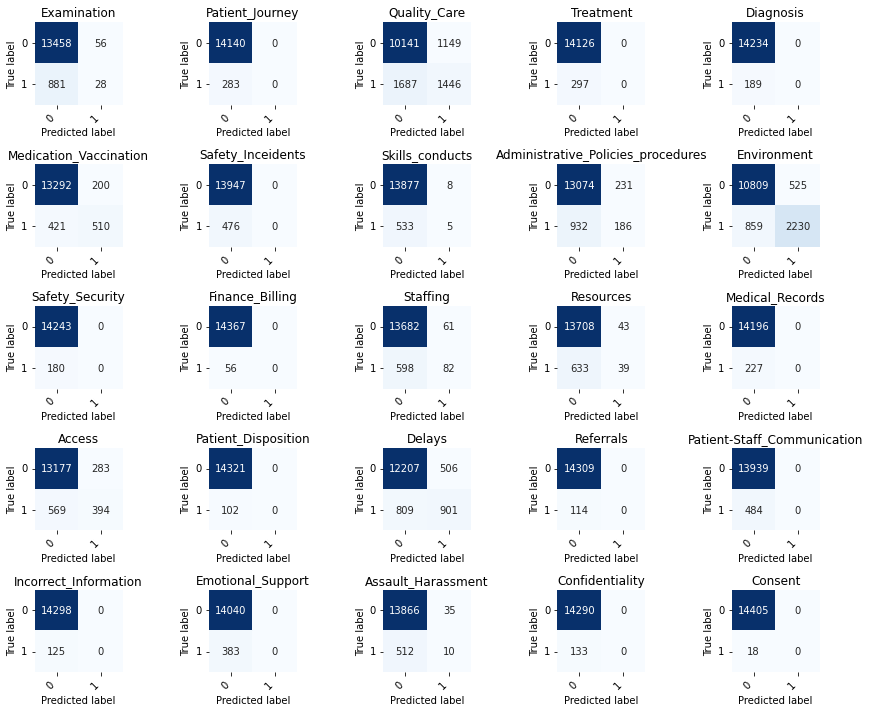

In [50]:
#from sklearn.metrics import  multilabel_confusion_matrix
cf_bilstm2 = multilabel_confusion_matrix(y_actual2_compound,y_preds2_compound)
import PlotConfusion
PlotConfusion.print_cf(cf_bilstm2,cols)

In [ ]:
y_preds2 = model2.predict(x_te)

In [ ]:
"""
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
cf2 = multilabel_confusion_matrix(y_te.to_numpy(),np.ceil(np.round(y_preds2)))
print(cf2)

y_preds2_int = convert_preds(y_preds2)
print(classification_report(y_te,y_preds2_int))
"""

'\nfrom sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix\ncf2 = multilabel_confusion_matrix(y_te.to_numpy(),np.ceil(np.round(y_preds2)))\nprint(cf2)\n\ny_preds2_int = convert_preds(y_preds2)\nprint(classification_report(y_te,y_preds2_int))\n'

In [ ]:
#model2.save('BiLSTM_PX_W2V_10Fold_1st.h5')

In [ ]:
model2.evaluate(padded_comments[test], Y_list[test])

####~explain the preditions - old stuff~


In [ ]:
classes_names = np.array(px_df1.columns[3:])
print(classes_names)

if False:
    skip="""
{'Examination':0,
                 'Patient_Journey':1,
                 'Quality_Care':2,
                 'Treatment':3,
                 'Diagnosis':4,
                 'Medication_Vaccination':5,
                 'Safety_Inceidents':6,
                 'Skills_conducts':7,
                 'Administrative_Policies_procedures':8,
                 'Environment':9,
                 'Safety_Security':10,
                 'Finance_Billing':11,
                 'Staffing':12,
                 'Resources':13,
                 'Medical_Records':14,
                 'Access':15,
                 'Patient_Disposition':16,
                 'Delays':17,
                 'Referrals':18,
                 'Patient-Staff_Communication':19,
                 'Incorrect_Information':20,
                 'Emotional_Support':21,
                 'Assault_Harassment':22,
                 'Confidentiality':23,
                 'Consent':24}
                 
"""

In [ ]:
# aravec + BiLSTM prediction
predict1 = model1.predict(x_te)

In [ ]:
print(predict1[0:3])
print('\n' , predict1[0:3].round(decimals=1))
print('\n' , np.ceil(predict1[0:3].round(decimals=1)))

In [ ]:
# this function takes a list of predictions and returns a dictionary where K = index of preds, V = the corresponding labels
def check_top_labels(preds ,top_n=10):
    labels_within = dict()
    for i in range(0,len(preds)):
        ceiled_labels = np.ceil(preds[i].round(decimals=1))
        label_text = ''
        for j in range(0,len(ceiled_labels)):
            if (ceiled_labels[j] > 0):
                label_text = label_text + classes_names[j] + ', '
        labels_within.update({i:label_text})
    return labels_within

In [ ]:
temp = check_top_labels(predict1[0:30]) # show the text and labels for each 
for k,v in temp.items():
    print('predictected text : ' ,px_df1.cleaned_comment[11541+k], 'at index: ', k , ' has classes: ' , v , '\n')

# 3.Hyperparameter tuning for the BiLSTM model
We are going to perform Random_search rather than grid search.

The factors to manipulate are:

number of neurons, number of hidden layers, activation functions, optimizers, learning rate,batch size, epochs, regularization.


x_tr, x_te, y_tr, y_te

## ~Attempt 1: using sklearn - FAILED~

In [ ]:
"""

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

def create_model(name='', optimizer='adam', activation='relu', dropo=0.2, hl=64, learn_rate=0.01):
    
    model = Sequential(name=name)
    # stack layers:
    model.add(Embedding(vocab_size, 300 ,weights=[embedding_matrix], input_length=MAX_LENGTH))
    model.add(Bidirectional(GRU(hl,return_sequences=True)))
    model.add(Dropout(dropo))
    #model.add(Bidirectional(GRU(32)))
    #model.add(Dropout(dropo))
    model.add(Dense(25, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m,metrics.AUC(),metrics.FalseNegatives(),metrics.FalsePositives(), metrics.TrueNegatives(),metrics.TruePositives(),])
    #print(model.summary())
    return model



# tune OPTIMIZERS , BATCH_SIZE , ACTIVATION
# activation=['relu','tanh'],
params = dict(optimizer = ['sgd','adam','RMSprop'], epochs= [5,10], batch_size=[5,10,20],
               learn_rate=[0.001, 0.01, 0.1, 0.2, 0.3])#,name='tune OPTIMIZERS , BATCH_SIZE , ACTIVATION')

model_rm= KerasClassifier(build_fn=create_model) # n_jobs = cores of CPU
random1 = RandomizedSearchCV(model_rm , param_distributions=params, cv=3, 
                             n_jobs=6, scoring=f1_m) # make_scorer(['accuracy','f1_macro','f1_weighted'])

random1_res = random1.fit(x_tr, y_tr) #history

print('Best: ',random1_res.best_score_,' ,best parameters ' , random1_res.best_params_)
print(random1_res)

print('Estimator: ',
    random1_res.best_estimator_,'\nParameters: ',
    random1_res.best_params_,'\nScore: ',
    random1_res.best_score_,'\n',)


"""

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


## Attempt 2: using **KERAS TUNER**

### First_tuned BiLSTM

In [ ]:
print( x_tr.shape , 'x testing set shape: ' , x_te.shape)
print( y_tr.shape , 'y training set shape: ' , y_te.shape)

(11536, 128) x testing set shape:  (2887, 128)
(11536, 25) y training set shape:  (2887, 25)


In [ ]:
#https://keras.io/guides/keras_tuner/getting_started/

"""
import tensorflow as tf
class val_f1_tfa(tfk.metrics.Metric):
    def __init__(self, **kwargs):
        # Specify the name of the metric as "custom_metric".
        super().__init__(name="val_f1_tfa", **kwargs)
        #attribute
        self.f1 = self.add_weight(name="f1",dtype=tf.float32, initializer="zeros")
        self.f1score = tfa.metrics.F1Score(num_classes=25, average="micro", threshold=None) #self.add_weight(name="f1score",dtype=tf.float64, initializer="zeros")


    def update_state(self, y_true, y_pred, sample_weight=None):
        #self.f1score.assign_add(tfa.metrics.F1Score(num_classes=25, average="micro", threshold=None))
        self.f1score.update_state(y_true,y_pred)
        self.f1.assign_add(self.f1score.result())

    def result(self):
        return self.f1

    def reset_states(self):
        self.f1.assign(0)
        self.f1score.assign(0)

def val_f1score_method(y_true,y_pred):
    val_fbeta_score.update_state(y_true,y_pred)
"""        
from sklearn.metrics import f1_score
def val_f1_micro(y_true, y_pred):
  f1_micro = f1_score(y_true, y_pred, average='micro')
  return f1_micro

def val_f1_macro(y_true, y_pred):
  f1_micro = f1_score(y_true, y_pred, average='macro')
  return f1_micro

def val_f1_wighted(y_true, y_pred):
  f1_micro = f1_score(y_true, y_pred, average='weighted')
  return f1_micro


# this 
def val_f1_hp(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:

def build_model(hp): #just for the purpose of experimenting if it's going to show the F1.
    modelx = tfk.Sequential()
    
    modelx.add(tfk.layers.Embedding(vocab_size, MAX_LENGTH ,weights=[embedding_matrix] , input_length=MAX_LENGTH))

    
    # Tune number of hidden layers:
    for i in range(hp.Int('num_layers', 2,8)): # units , 16, 32, 64, 128 #'relu','tanh','sigmoid','hard_sigmoid','linear'
        modelx.add(tfk.layers.Bidirectional(tfk.layers.LSTM(hp.Choice('units',[8, 16, 32, 64, 128]),
                                                       hp.Choice('activation',['relu','tanh','sigmoid']),
                                                       recurrent_dropout=0.2,return_sequences=True,)))
        modelx.add(tfk.layers.Dropout(rate=0.2))
    # Tune whether to use dropout.
    #if hp.Boolean("dropout"):
    #modelx.add(tfk.layers.Dropout(rate=0.2))
    # another BI-LSTM layer that doesn't return_sequence.
    modelx.add(tfk.layers.Bidirectional(tfk.layers.LSTM(32)))
    modelx.add(tfk.layers.Dropout(0.2))
    # Output layer
    modelx.add(tfk.layers.Dense(25, activation='sigmoid'))
#hp.Choice('optimizer',['adam', 'sgd'])
# 'Adam', 'SGD', 'RMSprop' , 'Adagrad' , 'Adamax' , 'Nadam' , 'Adadelta'
    modelx.compile(optimizer= hp.Choice('optimizer',['Adam', 'SGD', 'RMSprop']),
                   loss=keras.losses.BinaryCrossentropy(), 
                   metrics=['accuracy',val_f1_hp, val_f1_micro, val_f1_macro, val_f1_wighted,
                            precision_m, recall_m,metrics.Precision(), metrics.Recall() ,metrics.AUC(),metrics.FalseNegatives(),
                            metrics.FalsePositives(), metrics.TrueNegatives(),metrics.TruePositives()])

    return modelx


In [ ]:
# Random Search
# objective= kt.Objective('val_f1_hp', direction='max') #trials = 100
tuner = kt.RandomSearch(build_model, objective= kt.Objective('loss', direction='min'),max_trials=10, project_name='px_lstm_tuned1',distribution_strategy=tf.distribute.MirroredStrategy() ,)#directory='x_BiLSTM_PXWE_Tuned_30trails',)
tuner.search_space_summary() # 315 different combination

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 1, 'sampling': None}
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'SGD', 'RMSprop'], 'ordered': False}


In [ ]:
#val_fbeta_score.reset_states()
# tensorflow==2.7.0
tuner.search(x_tr, y_tr, epochs=5) #5



In [ ]:
!rm -rf px_lstm_tuned1

In [ ]:
"""
best_model = tuner.get_best_models()[0]
best_model.summary()
print(type(best_model))
"""

#tf.keras.utils.custom_object_scope({'my_regularizer': my_regularizer})
#tf.keras.utils.custom_object_scope({'val_f1_metric': })

In [ ]:
# grab the best model, check it's values
best_hp = tuner.get_best_hyperparameters()[0]
model_hp = tuner.hypermodel.build(best_hp)
print(type(best_hp) , '  , ', type(model_hp), '  ,  ' , )
#print(best_hp.get)

<class 'keras_tuner.engine.hyperparameters.HyperParameters'>   ,  <class 'keras.engine.sequential.Sequential'>   ,  


In [ ]:
model_hp.summary()
from keras.models import load_model
#model_hp.save('BiLSTM_AraVec_tuned_50trails.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          9901500   
                                                                 
 bidirectional_3 (Bidirectio  (None, 300, 128)         140544    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 300, 128)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 300, 128)         74496     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 300, 128)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 300, 128)        

In [ ]:
print('Activation:' , best_hp.get('activation'), '\nOptimizer:' ,best_hp.get('optimizer'), '\nUnits:' ,best_hp.get('units'),'\nNumber of layers: ' , best_hp.get('num_layers'))



Activation: tanh 
Optimizer: RMSprop 
Units: 64 
Number of layers:  3


In [ ]:
historyx = model_hp.fit(x_tr, y_tr, batch_size=128 , epochs= 10)

Epoch 1/10
91/91 [==============================] - 173s 2s/step - loss: 0.2115 - accuracy: 0.1680 - val_f1_hp: 0.0149 - precision_m: 0.2280 - recall_m: 0.0161 - auc_1: 0.6855 - false_negatives_1: 14466.0000 - false_positives_1: 2814.0000 - true_negatives_1: 271007.0000 - true_positives_1: 238.0000
Epoch 2/10
91/91 [==============================] - 174s 2s/step - loss: 0.1680 - accuracy: 0.2949 - val_f1_hp: 0.1240 - precision_m: 0.6289 - recall_m: 0.0704 - auc_1: 0.7914 - false_negatives_1: 13683.0000 - false_positives_1: 601.0000 - true_negatives_1: 273220.0000 - true_positives_1: 1021.0000
Epoch 3/10
91/91 [==============================] - 179s 2s/step - loss: 0.1513 - accuracy: 0.3978 - val_f1_hp: 0.2743 - precision_m: 0.6785 - recall_m: 0.1741 - auc_1: 0.8411 - false_negatives_1: 12143.0000 - false_positives_1: 1237.0000 - true_negatives_1: 272584.0000 - true_positives_1: 2561.0000
Epoch 4/10
91/91 [==============================] - 179s 2s/step - loss: 0.1391 - accuracy: 0.4494 

In [ ]:
print(historyx.history.keys())

dict_keys(['loss', 'accuracy', 'val_f1_hp', 'precision_m', 'recall_m', 'auc_1', 'false_negatives_1', 'false_positives_1', 'true_negatives_1', 'true_positives_1'])


In [ ]:

evaluation_hp = model_hp.evaluate(x_te,y_te, verbose=0)
#print('Loss: ',loss1,' Accuracy: ',accuracy1,' F1_Score: ', f1_score1, ' Precision: ', precision1,' Recall: ',recall1, ' AUC: ',auc1,'FN ', fn1, ' FP: ', fp1,' TN: ', tn1, ' TP: ', tp1) 


In [ ]:
print(model_hp.metrics_names ,'\n\n' , evaluation_hp)
#print(evaluation_hp)

['loss', 'accuracy', 'val_f1_hp', 'precision_m', 'recall_m', 'auc_1', 'false_negatives_1', 'false_positives_1', 'true_negatives_1', 'true_positives_1'] 

 [0.08210258185863495, 0.5287595391273499, 0.6195175051689148, 0.7596012353897095, 0.5347651243209839, 0.9122679233551025, 1197.0, 397.0, 69121.0, 1435.0]
